Make a copy of this notebook and rename using your USERID in the following format, 2017CSZ8058

Give editor access to keshavkolluru@gmail.com, vishalsaley114@gmail.com and kartikeya.badola@gmail.com


# Imports

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 34.4 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1bCA_qPrG0QG4viuXvUYziYalMUwHDSBX&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1bCA_qPrG0QG4viuXvUYziYalMUwHDSBX
To: /content/Extra_dataset.csv
100% 3.06M/3.06M [00:00<00:00, 97.3MB/s]


In [ ]:
# DONT CHANGE THIS CELL
!wget http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip

--2021-10-25 14:38:38--  http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip
Resolving www.cse.iitd.ac.in (www.cse.iitd.ac.in)... 103.27.9.152
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip [following]
--2021-10-25 14:38:38--  https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217313 (212K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 212.22K   114KB/s    in 1.9s    

2021-10-25 14:38:41 (114 KB/s) - ‘data.zip’ saved [217313/217313]



In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train.gold.txt  
  inflating: data/train/train.data.txt  
   creating: data/validation/
  inflating: data/validation/validation.data.txt  
  inflating: data/validation/validation.gold.txt  


In [ ]:
# !gdown https://drive.google.com/u/0/uc?id=1EWYnZmxw_XZtGRA0Dy3dAHY4_s005fMV&export=download

# Data Read

In [ ]:
import sys
import re
def cleaning(text):
  text= text.lower()
  text=text.strip()
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  replace_dot = re.compile("\.")
  text = replace_dot.sub(' ', text)
  replace_q = re.compile("\?")
  text = replace_q.sub('', text)
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub('' , text)
  text = BAD_SYMBOLS_RE.sub('',text)  
  return text

In [ ]:
import pandas as pd
df_train_data = pd.read_csv('data/train/train.data.txt', sep ="\t",names = ['word', 'status', 'position','sentence1','sentence2'])
df_train_data['sentence1']=df_train_data['sentence1'].apply(cleaning)
df_train_data['sentence2']=df_train_data['sentence2'].apply(cleaning)

df_train_label = pd.read_csv('data/train/train.gold.txt', sep ="\n",names = ['label'])

In [ ]:
df_val = pd.read_csv('data/validation/validation.data.txt', sep ="\t",names = ['word', 'status', 'position','sentence1','sentence2'])
df_val['sentence1']=df_val['sentence1'].apply(cleaning)
df_val['sentence2']=df_val['sentence2'].apply(cleaning)

df_val_label = pd.read_csv('data/validation/validation.gold.txt', sep ="\t",names = ['label'])

In [ ]:
df_extra = pd.read_csv("Extra_dataset.csv")
df_extra['sentence1']=df_extra['sentence1'].apply(cleaning)
df_extra['sentence2']=df_extra['sentence2'].apply(cleaning)

In [ ]:
# df_extra = pd.read_csv("Extra_dataset_train_dev.csv")
# df_extra['sentence1']=df_extra['sentence1'].apply(cleaning)
# df_extra['sentence2']=df_extra['sentence2'].apply(cleaning)

In [ ]:
train_df = pd.DataFrame()
train_df['gold_label'] = df_train_label['label']
train_df['sentence1'] = df_train_data['sentence1']
train_df['sentence2'] = df_train_data['sentence2']
train_df = train_df.reindex(columns=['gold_label', 'sentence1', 'sentence2'])
train_df = train_df.append(df_extra)

val_df = pd.DataFrame()
val_df['gold_label'] = df_val_label['label']
val_df['sentence1'] = df_val['sentence1']
val_df['sentence2'] = df_val['sentence2']
val_df = val_df.reindex(columns=['gold_label', 'sentence1', 'sentence2'])


In [ ]:
train_df['sentence1'] = train_df['sentence1'].astype(str)
train_df['sentence2'] = train_df['sentence2'].astype(str)

In [ ]:
val_df['sentence1'] = val_df['sentence1'].astype(str)
val_df['sentence2'] = val_df['sentence2'].astype(str)

In [ ]:
train_df = train_df[(train_df['sentence1'].str.split().str.len() > 0) & (train_df['sentence2'].str.split().str.len() > 0)]
val_df = val_df[(val_df['sentence1'].str.split().str.len() > 0) & (val_df['sentence2'].str.split().str.len() > 0)]

# Model

In [ ]:
## Import relevant packages

import os

import time
import datetime

import torch
torch.cuda.empty_cache()
import torch.optim as O
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from transformers import BertConfig
import pickle

import logging
from argparse import ArgumentParser

from pdb import set_trace

import pandas as pd
import numpy as np

In [ ]:
#Reproducing same results
SEED = 2021

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [ ]:
## Various utility functions

def parse_args():
	args = {
		'dataset':"wsd",
		'model':"bert",
		'gpu':0,
		'batch_size':64,
		'epochs':4,
		'lr':2e-5,
		'combine':"cat",
		'results_dir':"results"
	}
	return check_args(args)

"""checking arguments"""
def check_args(args):
	# --result_dir
	check_folder(os.path.join(args['results_dir'], args['model'], args['dataset']))

	# --epoch
	try:
			assert args['epochs'] >= 1
	except:
			print('number of epochs must be larger than or equal to one')

	# --batch_size
	try:
			assert args['batch_size'] >= 1
	except:
			print('batch size must be larger than or equal to one')
	return args

def get_device(gpu_no):
	if torch.cuda.is_available():
		torch.cuda.set_device(gpu_no)
		return torch.device('cuda:{}'.format(gpu_no))
	else:
		return torch.device('cpu')

def makedirs(name):
	"""helper function for python 2 and 3 to call os.makedirs()
		avoiding an error if the directory to be created already exists"""

	import os, errno

	try:
		os.makedirs(name)
	except OSError as ex:
		if ex.errno == errno.EEXIST and os.path.isdir(name):
			# ignore existing directory
			pass
		else:
			# a different error happened
			raise

def check_folder(log_dir):
	if not os.path.exists(log_dir):
		os.makedirs(log_dir)
	return log_dir

def get_logger(args, phase):
	logging.basicConfig(level=logging.INFO, 
												filename = "{}/{}/{}/{}.log".format(args['results_dir'], args['model'], args['dataset'], phase),
												format = '%(asctime)s - %(message)s', 
												datefmt='%d-%b-%y %H:%M:%S')
	return logging.getLogger(phase)

In [ ]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

class DataBert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'F': 0, 'T': 1}
    self.train_df = train_df
    self.val_df = val_df

    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 100
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    s1_list = df['sentence1'].to_list()
    s2_list = df['sentence2'].to_list()
    label_list = df['gold_label'].to_list()

    for (s1, s2, label) in zip(s1_list, s2_list, label_list):
      s1_id = self.tokenizer.encode(s1, add_special_tokens = False)
      s2_id = self.tokenizer.encode(s2, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + s1_id + [self.tokenizer.sep_token_id] + s2_id + [self.tokenizer.sep_token_id]
      s1_len = len(s1_id)
      s2_len = len(s2_id)

      segment_ids = torch.tensor([0] * (s1_len + 2) + [1] * (s2_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (s1_len + s2_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=64, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

In [ ]:
## Basic training loop
from transformers import BertForSequenceClassification, AdamW

class Train():
	def __init__(self):
		print("program execution start: {}".format(datetime.datetime.now()))
		self.args = parse_args()
		self.device = get_device(self.args['gpu'])
		self.logger = get_logger(self.args, "train")
		self.logger.info("Arguments: {}".format(self.args))
		self.model_options = parse_args()
		dataset_options = {
											'batch_size': self.args['batch_size'], 
											'device': self.device
										}

		## TODO: Load your own dataset
		self.dataset = DataBert(train_df, val_df)
		self.train_loader, self.val_loader = self.dataset.get_data_loaders()

		self.config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.2, num_labels=2)
		self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config =self.config)
		self.model.to(self.device)
	
		param_optimizer = list(self.model.named_parameters())
		no_decay = ['bias', 'gamma', 'beta']
		self.optimizer_grouped_parameters = [
				{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
				'weight_decay_rate': 0.01},
				{'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
				'weight_decay_rate': 0.0}
		]
		self.opt = AdamW(self.optimizer_grouped_parameters, lr = self.args['lr'], correct_bias=False)
		self.best_val_acc = None
		self.scheduler = StepLR(self.opt, step_size=5, gamma=0.5)
		print("resource preparation done: {}".format(datetime.datetime.now()))

	def result_checkpoint(self, epoch, train_loss, val_loss, train_acc, val_acc, took):
		if self.best_val_acc is None or val_acc > self.best_val_acc:
			self.best_val_acc = val_acc
			torch.save({
				'accuracy': self.best_val_acc,
				'options': self.model_options,
				'model_dict': self.model.state_dict(),
			}, '{}/{}/{}/best-{}-{}-params.pt'.format(self.args['results_dir'], self.args['model'], self.args['dataset'], self.args['model'], self.args['dataset']))
		self.logger.info('| Epoch {:3d} | train loss {:5.2f} | train acc {:5.2f} | val loss {:5.2f} | val acc {:5.2f} | time: {:5.2f}s |'
				.format(epoch, train_loss, train_acc, val_loss, val_acc, took))
	
	def train(self):
		total_step = len(self.train_loader)
		for epoch in range(self.args['epochs']):
			self.model.train()
			total_train_loss = 0
			total_train_acc  = 0	
		
			for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(self.train_loader):
				self.opt.zero_grad()
				pair_token_ids = pair_token_ids.to(self.device)
				mask_ids = mask_ids.to(self.device)
				seg_ids = seg_ids.to(self.device)
				labels = y.to(self.device)
				loss, prediction = self.model(pair_token_ids, 
															token_type_ids=seg_ids, 
															attention_mask=mask_ids, 
															labels=labels).values()
				acc = accuracy_(prediction, labels)
				
				loss.backward()
				torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
				self.opt.step()
		
				total_train_loss += loss.item()
				total_train_acc  += acc.item()

		train_acc  = total_train_acc/len(self.train_loader)
		train_loss = total_train_loss/len(self.train_loader)
		return train_loss, train_acc 

	def validate(self):
		self.model.eval()
		total_val_acc = 0
		total_val_loss = 0
		with torch.no_grad():
			for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(self.val_loader):
				self.opt.zero_grad()
				pair_token_ids = pair_token_ids.to(self.device)
				mask_ids = mask_ids.to(self.device)
				seg_ids = seg_ids.to(self.device)
				labels = y.to(self.device)
				loss, prediction = self.model(pair_token_ids, 
															token_type_ids=seg_ids, 
															attention_mask=mask_ids, 
															labels=labels).values()
				acc = accuracy_(prediction, labels)

				total_val_loss += loss.item()
				total_val_acc  += acc.item()

			val_acc  = total_val_acc/len(self.val_loader)
			val_loss = total_val_loss/len(self.val_loader)
			
		return val_loss, val_acc

	def execute(self):
		print(" [*] Training starts!")
		print('-' * 99)
		for epoch in range(1, self.args['epochs']+1):
			start = time.time()

			train_loss, train_acc = self.train()
			val_loss, val_acc = self.validate()
			self.scheduler.step()
			
			took = time.time()-start
			self.result_checkpoint(epoch, train_loss, val_loss, train_acc, val_acc, took)

			print('| Epoch {:3d} | train loss {:5.2f} | train acc {:5.2f} | val loss {:5.2f} | val acc {:5.2f} | time: {:5.2f}s |'.format(
				epoch, train_loss, train_acc, val_loss, val_acc, took))
		self.finish()

	def finish(self):
		self.logger.info("[*] Training finished!\n\n")
		print('-' * 99)
		print(" [*] Training finished!")
		print(" [*] Please find the saved model and training log in results_dir")


In [ ]:
def accuracy_(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [ ]:
## Start training
task = Train()
task.execute()

In [ ]:
## Zip the final model and all the required files, such as vocabulary
# Replace USERID with your own, such as 2017CSZ8058
!zip -r 2020CSY7657_A_model.zip **

## Upload it to Google drive and ensure that the testing notebook uses the correct link

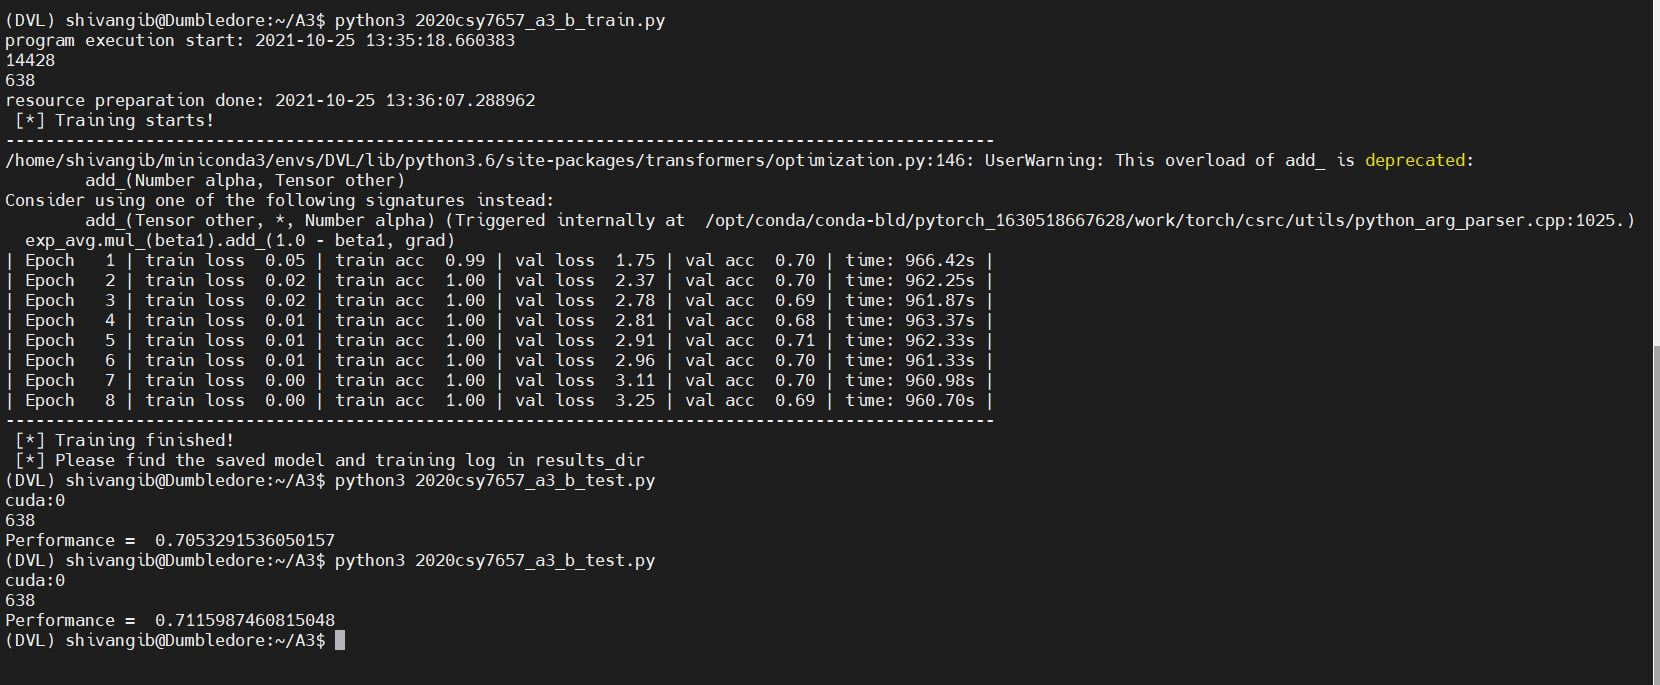

Trained the same on the V100 GPU and its taking less time there.

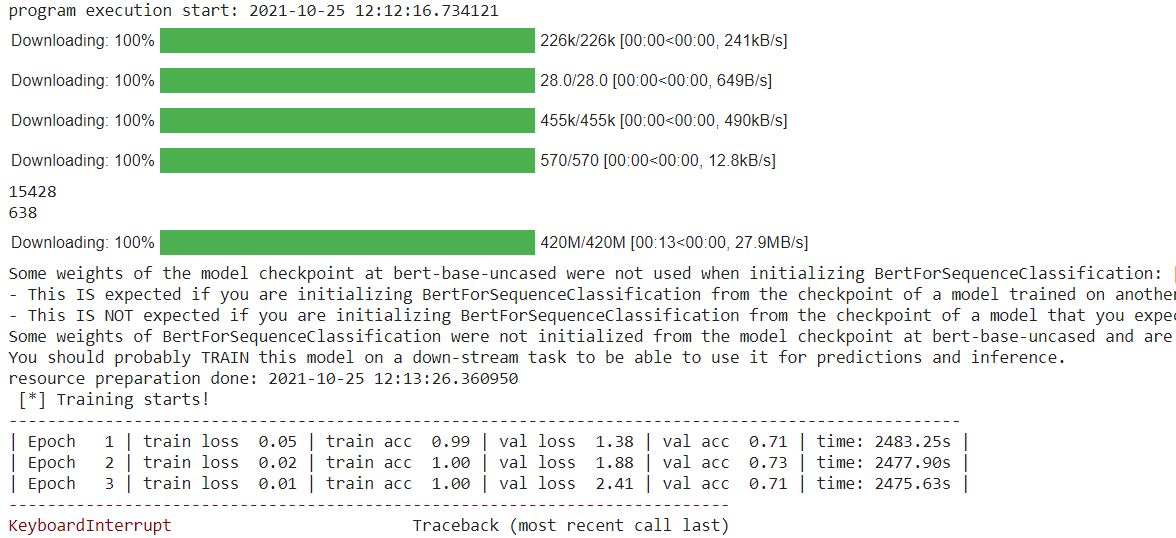

In [ ]:
# Taking more time here but less than 5 Hours